<a href="https://colab.research.google.com/github/aqsa135/BlackFriday-Analysis/blob/main/BlackFriday_Prediction_and_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


In [25]:
# Load data
data = pd.read_csv('./sample_data/BlackFriday.csv')


**Data Preprocessing**

In [27]:
# Handling missing values
imputer = SimpleImputer(strategy='most_frequent')
data['Product_Category_2'] = imputer.fit_transform(data[['Product_Category_2']])
data['Product_Category_3'] = imputer.fit_transform(data[['Product_Category_3']])


In [28]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,16.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,16.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,16.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,8.0,16.0,7969


In [29]:
# Encoding categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [30]:
# Normalizing features
scaler = StandardScaler()
data[['Purchase']] = scaler.fit_transform(data[['Purchase']])

**Exploratory Data Analysis**

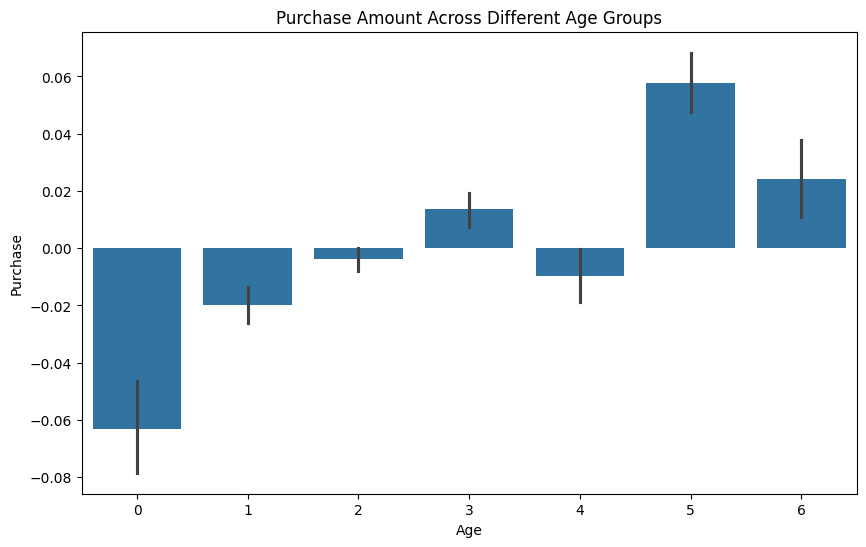

In [45]:
# Purchase Amount Across Different Age Groups
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='Purchase', data=data)
plt.title('Purchase Amount Across Different Age Groups')
plt.show()

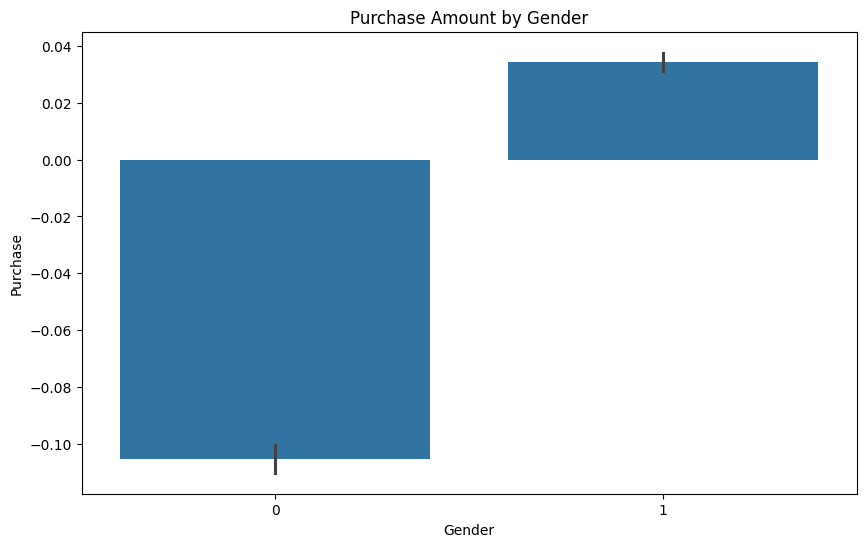

In [32]:
# Purchase Amount by Gender
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='Purchase', data=data)
plt.title('Purchase Amount by Gender')
plt.show()


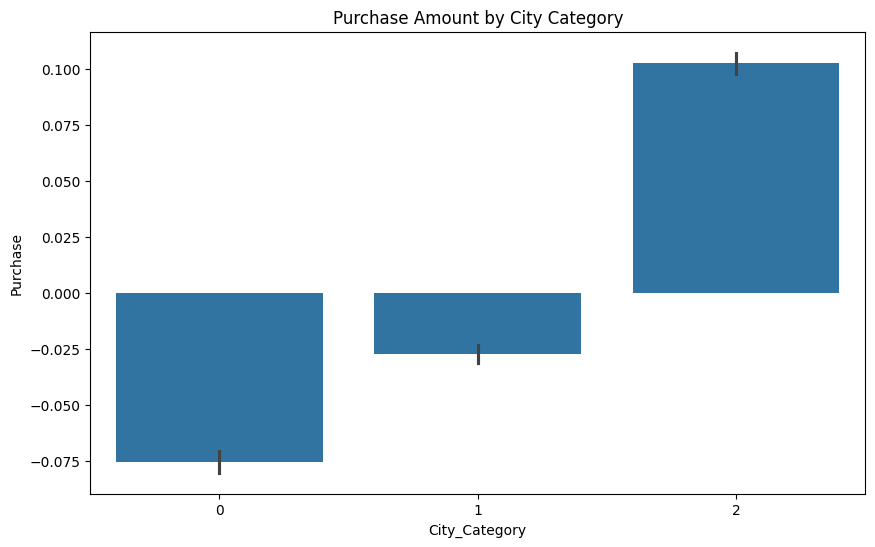

In [33]:
# City Category vs Purchase
plt.figure(figsize=(10, 6))
sns.barplot(x='City_Category', y='Purchase', data=data)
plt.title('Purchase Amount by City Category')
plt.show()

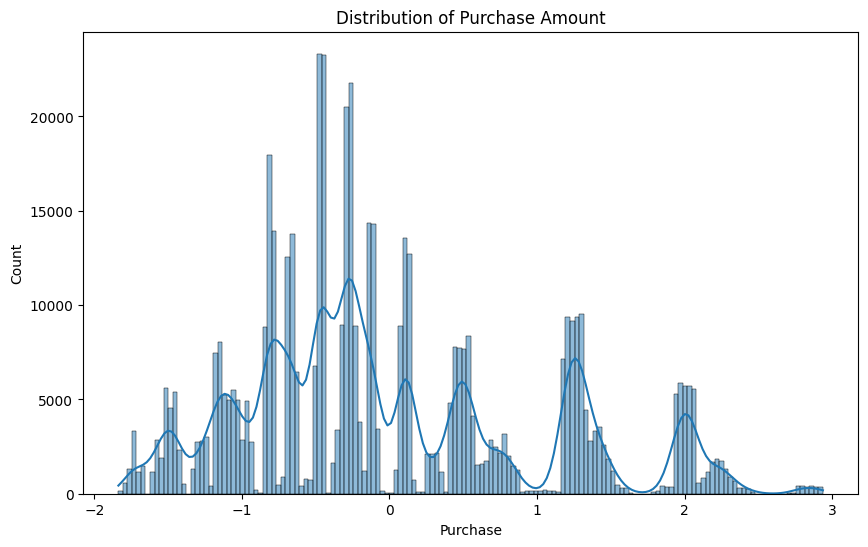

In [34]:
# Distribution of Purchase Amount
plt.figure(figsize=(10, 6))
sns.histplot(data['Purchase'], kde=True)
plt.title('Distribution of Purchase Amount')
plt.show()

<ipython-input-35-1f1fbd1ece10>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt=".2f")


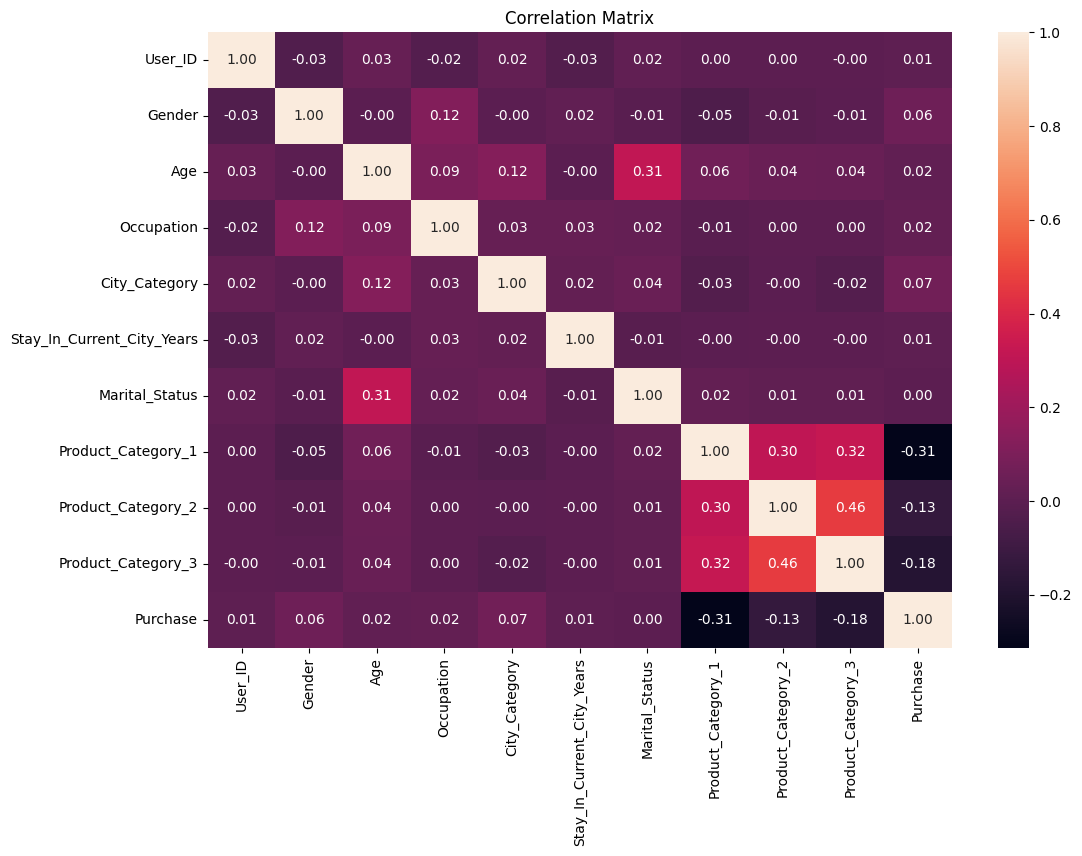

In [35]:
# Heatmap of Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**Customer Segmentation**


In [36]:
# Selecting relevant features for clustering
features_for_clustering = data[['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Purchase']]
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_for_clustering)



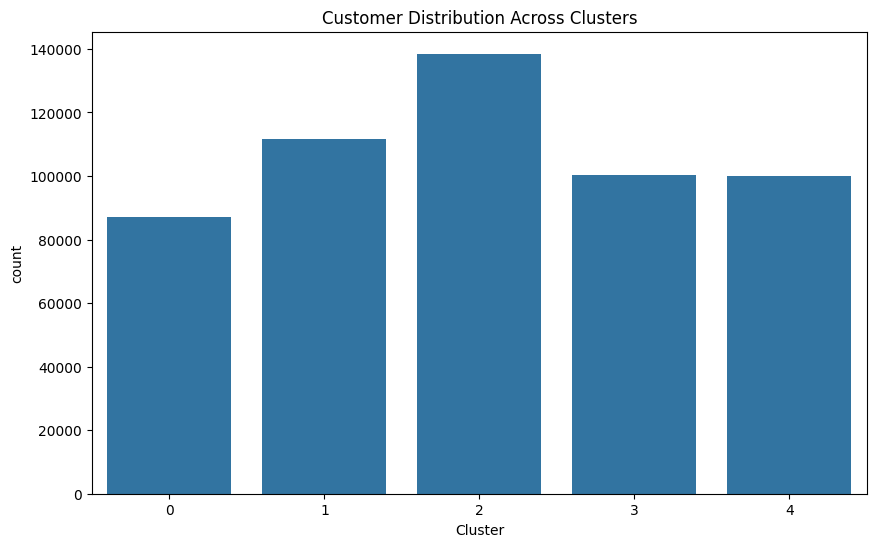

In [37]:
# Analyzing the clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=data)
plt.title('Customer Distribution Across Clusters')
plt.show()


**Predictive Modeling**


In [38]:
# Preparing data for the model
X = data.drop(['Purchase', 'User_ID', 'Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3'], axis=1)
y = data['Purchase']

In [39]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Gradient Boosting Regressor with full dataset
gb_model = GradientBoostingRegressor(random_state=42)

In [41]:
# Cross-validation
gb_mse = cross_val_score(gb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
gb_mse_avg = np.mean(-gb_mse)


In [42]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [100, 150]},
             scoring='neg_mean_squared_error')

In [43]:
# Best parameters and MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print(f"Initial Model MSE: {gb_mse_avg}")
print(f"Best Parameters from Grid Search: {best_params}")
print(f"Best MSE after Tuning: {best_mse}")

Initial Model MSE: 0.9857184834768781
Best Parameters from Grid Search: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Best MSE after Tuning: 0.9743031668873766


In [44]:
# Predicting and evaluating the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
print(f"Final Model MSE on Test Data: {final_mse}")

Final Model MSE on Test Data: 0.9746742988036998
